In this notebook we generate the carbon curves for each case and compare the results obtained from ws3 with libCBM

# Set up environment for each case study

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import os
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm_both

In [3]:
def select_case_study(case_study):
    print(f"Selected scenario: {case_study}")
case_study_dropdown = widgets.Dropdown(
    options=['mining_site_1', 'mining_site_2', 'mining_site_3', 'test'],
    value='test',
    description='Case Study:'
)
display(case_study_dropdown)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')

Dropdown(description='Case Study:', index=3, options=('redchris', 'goldenbear', 'equitysilver', 'test'), value…

In [10]:
case_study = case_study_dropdown.value

In [11]:
#Start Calculating the Running Time
Start = time.time()

In [12]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'

In [13]:
# Define case study mappings
case_study_options = {
    'mining_site_1': {
        'model_name': 'mining_site_1',
        'model_path': './data/woodstock_model_files_mining_site_1'
    },
    'mining_site_2': {
        'model_name': 'mining_site_2',
        'model_path': './data/woodstock_model_files_mining_site_2'
    },
    'mining_site_3': {
        'model_name': 'mining_site_3',
        'model_path': './data/woodstock_model_files_mining_site_3'
    },
    'test': {
        'model_name': 'mining_site_3',
        'model_path': './data/woodstock_model_files_mining_site_3_test'
    }
}

# Retrieve model details based on case study
model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


## Create and Run `ForestModel` instance

In [14]:
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

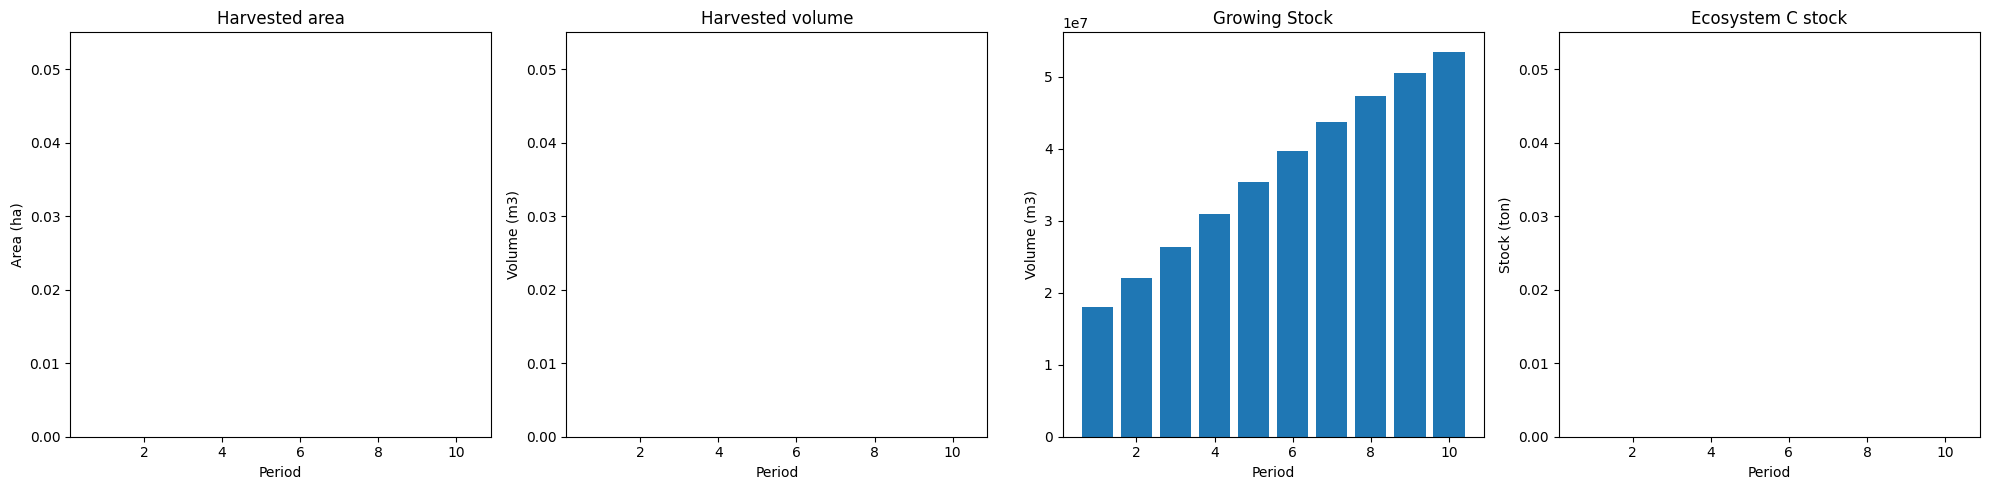

Plot saved to ./outputs/fig/redchris/redchris_max_st_test_scheduling_maxstock.pdf


(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

In [15]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm, case_study, obj_mode='max_st', scenario_name='test')
plot_scenario_maxstock(df, case_study, obj_mode='max_st', scenario_name='test')

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [16]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [17]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [18]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_emissionstock(sit_config, sit_tables, n_steps)

In [19]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                    
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [20]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

In [21]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

In [24]:
def cbm_report(fm, cbm_output, biomass_pools, dom_pools, total_emission, gross_growth, production, n_steps):
    
    # Add carbon pools indicators 
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    annual_carbon_stock = pd.DataFrame({'Year': pi['timestep'],
                                        'Biomass': pi[biomass_pools].sum(axis=1),
                                        'DOM': pi[dom_pools].sum(axis=1),
                                        'Ecosystem': pi[biomass_pools + dom_pools].sum(axis=1)})

    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    annual_all_emission = pd.DataFrame({'Year': fi['timestep'],
                                        'All_Emissions': fi[total_emission].sum(axis=1)})

    # Calculating gross growth fluxes
    annual_gross_growth = pd.DataFrame({'Year': fi['timestep'],
                                        'Gross_Growth': fi[gross_growth].sum(axis=1)})
    
    # Calculating HWPs carbon
    annual_harvested_carbon = pd.DataFrame({'Year': fi['timestep'],
                                            'Harvested_Carbon': fi[production].sum(axis=1)})


    # Calculating net emissions (All_Emissions - Gross_Growth)
    annual_net_emission = pd.DataFrame({'Year': fi['timestep'],
                                        'Net_Emissions': annual_all_emission['All_Emissions'] - annual_gross_growth['Gross_Growth']})

    df_cs = annual_carbon_stock.groupby('Year').sum()
    df_ae = annual_all_emission.groupby('Year').sum()
    df_gg = annual_gross_growth.groupby('Year').sum()  # Updated to Gross Growth
    df_ne = annual_net_emission.groupby('Year').sum()
    df_hc = annual_harvested_carbon.groupby('Year').sum()

    # Merging all dataframes, now including net emissions and gross growth
    merged_df = pd.merge(pd.merge(pd.merge(pd.merge(df_cs, df_ae, left_index=True, right_index=True, how='outer'),
                                           df_gg, left_index=True, right_index=True, how='outer'),
                                  df_ne, left_index=True, right_index=True, how='outer'),
                         df_hc, left_index=True, right_index=True, how='outer')

    # Calculating stock change
    merged_df['Stock_Change'] = merged_df['Ecosystem'].diff() * (-1)
    merged_df.at[0, 'Stock_Change'] = 0

    # Calculating (Stock Change - Harvested Carbon)
    merged_df['Stock_Change_minus_Harvested_Carbon'] = merged_df['Stock_Change'] - merged_df['Harvested_Carbon']

    # Plotting the graphs
    fig, axs = plt.subplots(8, 1, figsize=(10, 40))

    # Plot 1: Biomass Stock
    axs[0].plot(merged_df.index, merged_df['Biomass'], label='Biomass Stock', color='green')
    axs[0].set_title("Annual Biomass Stock")
    axs[0].set_xlabel("Year")
    axs[0].set_ylabel("Stock (ton C)")
    axs[0].set_xlim(0, n_steps)

    # Plot 2: DOM Stock
    axs[1].plot(merged_df.index, merged_df['DOM'], label='DOM Stock', color='brown')
    axs[1].set_title("Annual DOM Stock")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Stock (ton C)")
    axs[1].set_xlim(0, n_steps)

    # Plot 3: Ecosystem Stock
    axs[2].plot(merged_df.index, merged_df['Ecosystem'], label='Ecosystem Stock', color='blue')
    axs[2].set_title("Annual Ecosystem Stock")
    axs[2].set_xlabel("Year")
    axs[2].set_ylabel("Stock (ton C)")
    axs[2].set_xlim(0, n_steps)

    # Plot 4: All Emissions
    axs[3].plot(merged_df.index, merged_df['All_Emissions'], label='All Emissions', color='red')
    axs[3].set_title("Annual Total Ecosystem Carbon Emissions")
    axs[3].set_xlabel("Year")
    axs[3].set_ylabel("Emissions (ton C)")
    axs[3].set_xlim(0, n_steps)

    # Plot 5: Gross Growth
    axs[4].plot(merged_df.index, merged_df['Gross_Growth'], label='Gross Growth', color='purple')
    axs[4].set_title("Annual Gross Growth")
    axs[4].set_xlabel("Year")
    axs[4].set_ylabel("Growth (ton C)")
    axs[4].set_xlim(0, n_steps)

    # Plot 6: Net Emissions
    axs[5].plot(merged_df.index, merged_df['Net_Emissions'], label='Net Emissions', color='orange')
    axs[5].set_title("Annual Net Ecosystem Carbon Emissions")
    axs[5].set_xlabel("Year")
    axs[5].set_ylabel("Emissions (ton C)")
    axs[5].set_xlim(0, n_steps)

    # Plot 7: Stock Change
    axs[6].plot(merged_df.index, merged_df['Stock_Change'], label='Stock Change', color='cyan')
    axs[6].set_title("Annual Ecosystem Carbon Stock Change")
    axs[6].set_xlabel("Year")
    axs[6].set_ylabel("Stock Change (ton C)")
    axs[6].set_xlim(0, n_steps)

    # Plot 8: Harvested Carbon
    axs[7].plot(merged_df.index, merged_df['Harvested_Carbon'], label='Harvested Carbon', color='magenta')
    axs[7].set_title("Annual Harvested Carbon")
    axs[7].set_xlabel("Year")
    axs[7].set_ylabel("Harvested Carbon (ton C)")
    axs[7].set_xlim(0, n_steps)

    # Comparison plot for Net Emissions vs (Stock Change - Harvested Carbon)
    plt.figure(figsize=(10, 6))
    plt.plot(merged_df.index, merged_df['Net_Emissions'], label='Net Emissions', color='orange', linestyle='--')
    plt.plot(merged_df.index, merged_df['Stock_Change_minus_Harvested_Carbon'], 
             label='Stock Change - Harvested Carbon', color='blue')
    plt.title("Comparison of Annual Net Emissions and Annual (Stock Change - Harvested Carbon)")
    plt.xlabel("Year")
    plt.ylabel("Carbon (ton C)")
    plt.legend()

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

    return merged_df

### No-harvesting

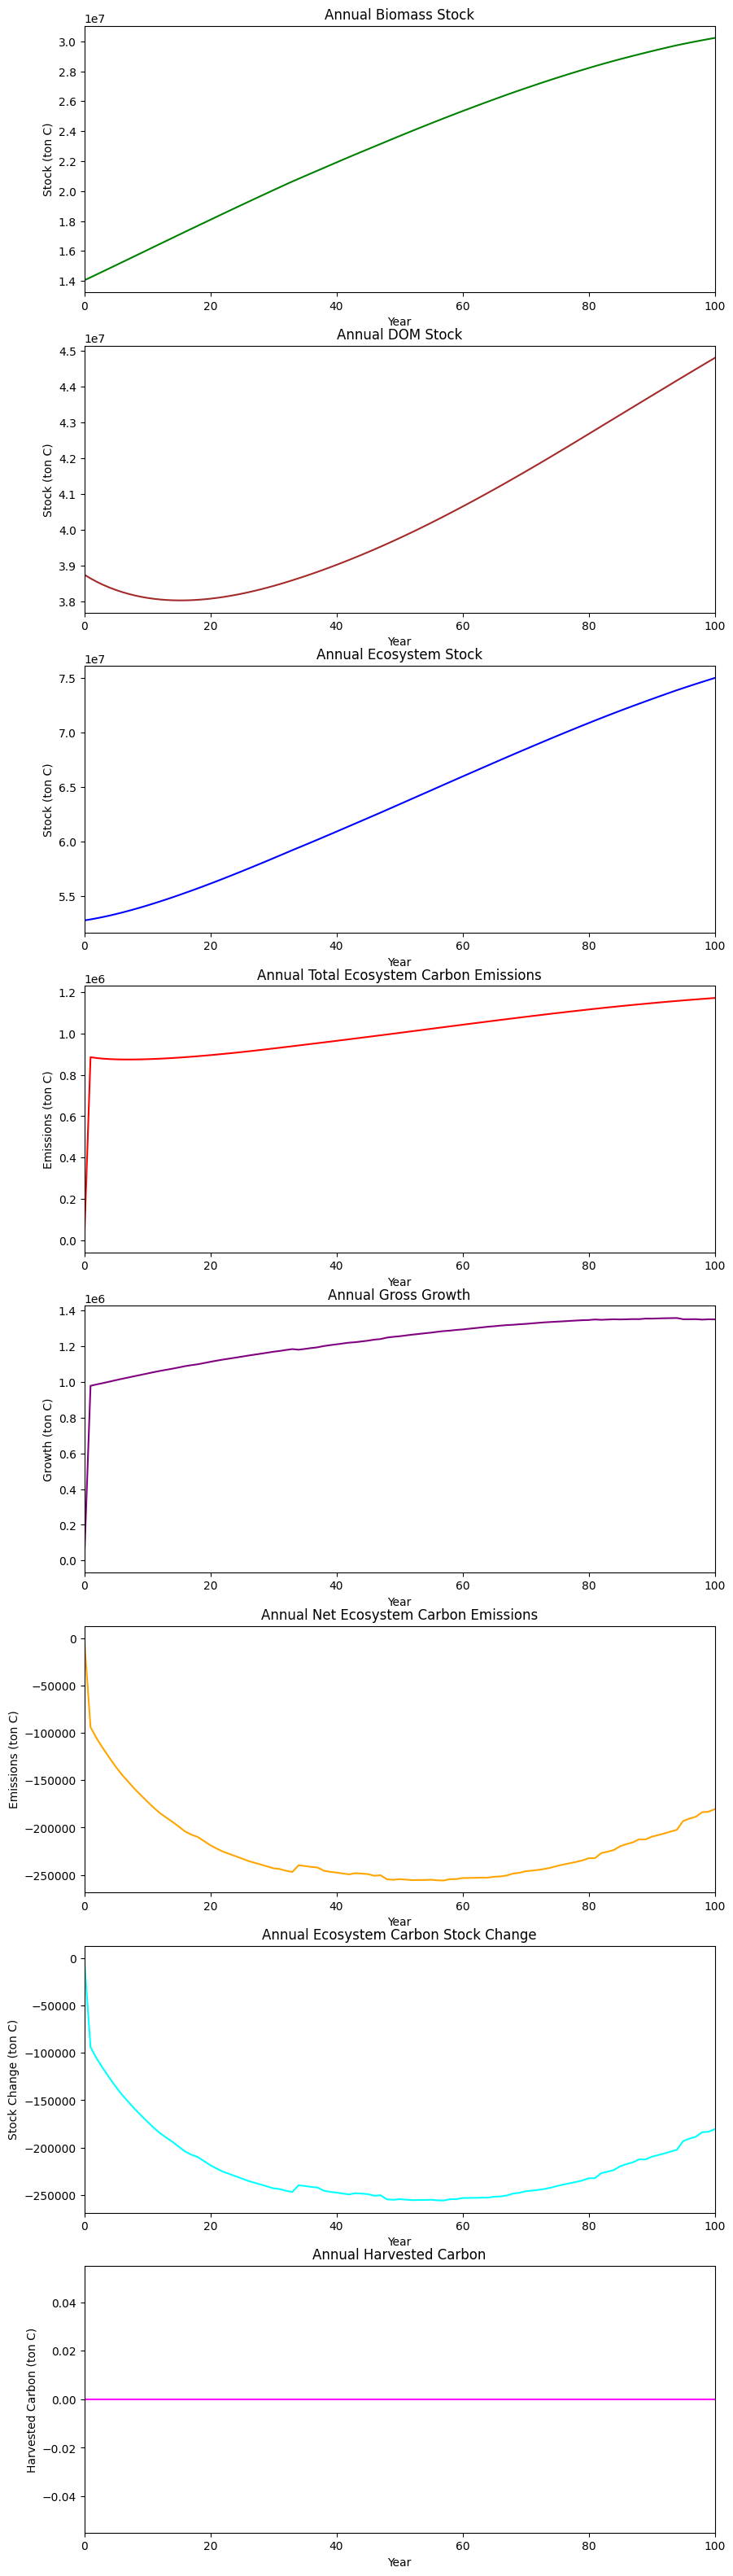

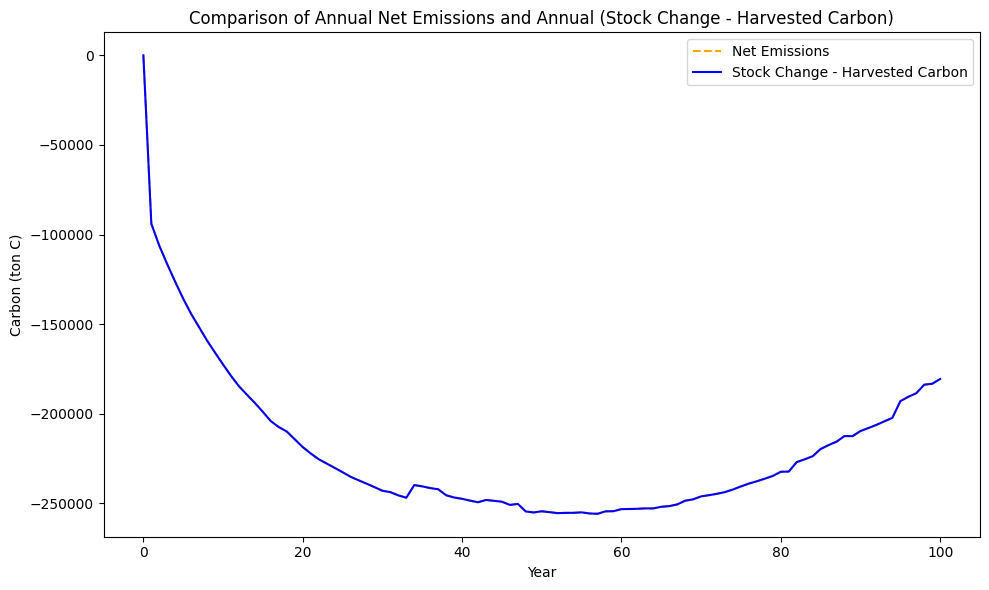

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Net_Emissions,Harvested_Carbon,Stock_Change,Stock_Change_minus_Harvested_Carbon
Year,,,,,,,,,
0,1.403745e+07,3.874220e+07,5.277965e+07,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000
1,1.423830e+07,3.863534e+07,5.287364e+07,8.850461e+05,9.790345e+05,-93988.459640,0.0,-93988.459640,-93988.459640
2,1.443963e+07,3.854026e+07,5.297989e+07,8.807935e+05,9.870460e+05,-106252.503460,0.0,-106252.503460,-106252.503460
3,1.464088e+07,3.845560e+07,5.309648e+07,8.778403e+05,9.944342e+05,-116593.865791,0.0,-116593.865791,-116593.865791
4,1.484254e+07,3.838034e+07,5.322289e+07,8.758588e+05,1.002263e+06,-126404.196888,0.0,-126404.196888,-126404.196888
...,...,...,...,...,...,...,...,...,...
96,2.990867e+07,4.437639e+07,7.428506e+07,1.161644e+06,1.352158e+06,-190514.038495,0.0,-190514.038495,-190514.038495
97,2.999184e+07,4.448176e+07,7.447360e+07,1.164035e+06,1.352573e+06,-188538.465314,0.0,-188538.465314,-188538.465314
98,3.007064e+07,4.458672e+07,7.465736e+07,1.166360e+06,1.350117e+06,-183756.250185,0.0,-183756.250185,-183756.250185


In [26]:
cbm_report(fm, cbm_output, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, n_steps)

## Generate and Add Carbon Yield Curves

Rebuild the inventory table. Set age to 1 and area to 1.0 ha.

The `sit_events` table should be empty.

In [27]:
sit_events = sit_tables['sit_events']

In [28]:
sit_events

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [29]:
sit_inventory = sit_tables['sit_inventory']

In [30]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,304,1,1,softwood,FALSE,2,8742.827683,0,0,fire,fire
1,tsa04,0,1,304,1,1,softwood,FALSE,56,29.340691,0,0,fire,fire
2,tsa04,0,1,304,1,1,softwood,FALSE,63,38.722559,0,0,fire,fire
3,tsa04,0,1,304,1,1,softwood,FALSE,66,104.486862,0,0,fire,fire
4,tsa04,0,1,304,1,1,softwood,FALSE,70,27.409778,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662,tsa04,1,42,1201,42,42,hardwood,FALSE,124,15.389482,0,0,fire,fire
3663,tsa04,1,42,1201,42,42,hardwood,FALSE,125,10.101145,0,0,fire,fire
3664,tsa04,1,42,1201,42,42,hardwood,FALSE,138,13.528389,0,0,fire,fire
3665,tsa04,1,42,1201,42,42,hardwood,FALSE,156,46.826669,0,0,fire,fire


In [31]:
# Set Age and Area to 1 and 1.0
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 1)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)
df

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,304,1,1,softwood,FALSE,1,1.0,0,0,fire,fire
1,tsa04,0,2,304,2,2,softwood,FALSE,1,1.0,0,0,fire,fire
2,tsa04,0,3,304,3,3,softwood,FALSE,1,1.0,0,0,fire,fire
3,tsa04,0,4,204,4,4,softwood,FALSE,1,1.0,0,0,fire,fire
4,tsa04,0,5,204,5,5,softwood,FALSE,1,1.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,tsa04,1,38,100,38,38,softwood,FALSE,1,1.0,0,0,fire,fire
60,tsa04,1,39,100,39,39,softwood,FALSE,1,1.0,0,0,fire,fire
61,tsa04,1,40,1201,40,40,hardwood,FALSE,1,1.0,0,0,fire,fire
62,tsa04,1,41,1201,41,41,hardwood,FALSE,1,1.0,0,0,fire,fire


Use the following code if any of the developments have no harvesting circumstances.

In [32]:
# # Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [33]:
# Run CBM and Generate CBM 0utputs
cbm_output_curves = run_cbm_emissionstock(sit_config, sit_tables, n_steps=700)

In [34]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [35]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [36]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[ecosystem_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [37]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [38]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0          1.933007e-10         0.000071          0.000   
                  1          8.648289e-09         0.000562          0.000   
                  2          7.989637e-08         0.001891          0.000   
                  3          3.869269e-07         0.004474          0.000   
                  4          1.315331e-06         0.008725          0.000   
...                                   ...              ...            ...   
tsa04 1 9 100 9 9 696        4.853751e+01         6.502583         25.075   
                  697        4.853751e+01         6.502583         25.075   
                  698        4.853751e+01         6.502583         25.075   
                  699        4.853751e+01         6.502583         25.075   
                  700        4.853751e+01         6.502583         25.075   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 0 1 304 1 1 0                    0.000009           0.000007   
                  1                    0.000072           0.000053   
                  2                    0.000241           0.000179   
                  3                    0.000570           0.000423   
                  4                    0.001112           0.000825   
...                                         ...                ...   
tsa04 1 9 100 9 9 696                 15.765563           2.019988   
                  697                 15.765563           2.019988   
                  698                 15.765563           2.019988   
                  699                 15.765563           2.019988   
                  700                 15.765563           2.019988   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
tsa04 1 9 100 9 9 696                 0.0              0.0            0.0   
                  697                 0.0              0.0            0.0   
                  698                 0.0              0.0            0.0   
                  699                 0.0              0.0            0.0   
                  700                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 0 1 304 1 1 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
tsa04 1 9 100 9 9 696                       0.0                0.0  ...   
                  697                       0.0                0.0  ...   
                  698                       0.0                0.0  ...   
                  699                       0.0                0.0  ...   
                  700                       0.0                0.0  ...   

                            MediumSoil  AboveGroundSlowSoil  \
dtype_key         timestep                                    
tsa04 0 1 3

In [40]:
c_curves_f['total_emission'] = 44/12 * c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = 44/12 * c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [42]:
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [43]:
c_curves_f

DisturbanceCO2Production  \
dtype_key         timestep                             
tsa04 0 1 304 1 1 0                              0.0   
                  1                              0.0   
                  2                              0.0   
                  3                              0.0   
                  4                              0.0   
...                                              ...   
tsa04 1 9 100 9 9 696                            0.0   
                  697                            0.0   
                  698                            0.0   
                  699                            0.0   
                  700                            0.0   

                            DisturbanceCH4Production  DisturbanceCOProduction  \
dtype_key         timestep                                                      
tsa04 0 1 304 1 1 0                              0.0                      0.0   
                  1                              0.0                      0.0   
                  2                              0.0                      0.0   
                  3                              0.0                      0.0   
                  4                              0.0                      0.0   
...                                              ...                      ...   
tsa04 1 9 100 9 9 696                            0.0                      0.0   
                  697                            0.0                      0.0   
                  698                            0.0                      0.0   
                  699                            0.0                      0.0   
                  700                            0.0                      0.0   

                            DisturbanceBioCO2Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 100 9 9 696                             0.0   
                  697                             0.0   
                  698                             0.0   
                  699                             0.0   
                  700                             0.0   

                            DisturbanceBioCH4Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 100 9 9 696                             0.0   
                  697                             0.0   
                  698                             0.0   
                  699                             0.0   
                  700                             0.0   

                            DisturbanceBioCOEmission  DecayDOMCO2Emission  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                              0.0             2.749185   
                  1                              0.0             2.749185   
                  2                              0.0             2.559418   
                  3                              0.0             2.399090   
                  4                              0.0             2.260498   
...                                              ...                  ...   
tsa04 1 9 100 9 9 696                            0.0             3.455147   
                  697                            0.0             3.4

In [44]:
# Use pickle.dump, to store the curves
file_directory = "./data/curves"
os.makedirs(file_directory, exist_ok=True)

file_data = {
    f"{case_study}_c_curves_p.pkl": c_curves_p,
    f"{case_study}_c_curves_f.pkl": c_curves_f
}

for filename, data in file_data.items():
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)
    print(f"File saved at {file_path}")


File saved at ./inputs/curves/redchris_c_curves_p.pkl
File saved at ./inputs/curves/redchris_c_curves_f.pkl


In [47]:
def plugin_c_curves(fm, c_curves_p, c_curves_f, pools, fluxes):
    # Dictionary to track registered curves for each dtype_key
    registered_curves = {}

    for dtype_key in fm.dtypes:
        dt = fm.dt(dtype_key)
        mask = ('?', '?', '?', '?', dtype_key[4], dtype_key[5])
        
        for _mask, ytype, curves in fm.yields:
            if _mask != mask: 
                continue  # Only proceed if the mask matches

            print('found match for mask', mask)

            # Initialize the tracking of registered curves for the dtype_key if not already done
            if dtype_key not in registered_curves:
                registered_curves[dtype_key] = set()

            # Register pool curves
            pool_data = c_curves_p.loc[' '.join(dtype_key)]
            for yname in pools:
                if yname not in registered_curves[dtype_key]:  # Check if curve is already registered
                    points = list(zip(pool_data.index.values, pool_data[yname]))
                    curve = fm.register_curve(ws3.core.Curve(yname, 
                                                             points=points, 
                                                             type='a', 
                                                             is_volume=False,
                                                             xmax=fm.max_age,
                                                             period_length=fm.period_length))
                    curves.append((yname, curve))
                    dt.add_ycomp('a', yname, curve)

                    # Mark the curve as registered
                    registered_curves[dtype_key].add(yname)

            # Register flux curves
            flux_data = c_curves_f.loc[' '.join(dtype_key)]
            for yname in fluxes:
                if yname not in registered_curves[dtype_key]:  # Check if curve is already registered
                    points = list(zip(flux_data.index.values, flux_data[yname]))
                    curve = fm.register_curve(ws3.core.Curve(yname, 
                                                             points=points, 
                                                             type='a', 
                                                             is_volume=False,
                                                             xmax=fm.max_age,
                                                             period_length=fm.period_length))
                    curves.append((yname, curve))
                    dt.add_ycomp('a', yname, curve)

                    # Mark the curve as registered
                    registered_curves[dtype_key].add(yname)


In [48]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f, sum_pools, sum_fluxes)

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '16', '16')
found match for mask ('?', '?', '?', '?', '17', '17')
found match for mask ('?', '?', '?', '?', '18', '18')
found match for mask ('?', '?', '?', '?', '19', '19')
found match for mask ('?', '?', '?', '?', '20', '20')
found match for mask ('?', '?', '?', '?', '21', '21')
found match for mask ('?', '?', '?', '?', '22'

In [49]:
# Check if all carbon yield curves are plugged in well.
# fm.yields

In [57]:
def compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, production, plots):
    eco_pools = biomass_pools + dom_pools
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])
    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    df_cbm = pd.DataFrame({
        'period': pi["timestep"] * 0.1, 
        'biomass_stock': pi[biomass_pools].sum(axis=1),
        'dom_stock': pi[dom_pools].sum(axis=1),
        'eco_stock': pi[eco_pools].sum(axis=1),
        'total_emission': 44/12 * fi[total_emission].sum(axis=1),
        'gross_growth': 44/12 * fi[gross_growth].sum(axis=1),
        'harvested_carbon': fi[production].sum(axis=1)
    }).groupby('period').sum().iloc[1::10, :].reset_index()

    df_cbm['period'] = (df_cbm['period'] + 0.9).astype(int)
    df_cbm['net_emission'] = df_cbm['total_emission'] - df_cbm['gross_growth']
    # df_cbm['eco_stock_change'] = df_cbm['eco_stock'].diff() * -1
    # df_cbm.at[0, 'eco_stock_change'] = 0.
    # df_cbm['sc-pr'] = df_cbm['eco_stock_change'] - df_cbm['harvested_carbon']

    df_ws3 = pd.DataFrame({
        'period': fm.periods,
        'biomass_stock': [fm.inventory(period, 'biomass') for period in fm.periods],
        'dom_stock': [fm.inventory(period, 'DOM') for period in fm.periods],
        'eco_stock': [fm.inventory(period, 'ecosystem') for period in fm.periods],
        'net_emission': [fm.inventory(period, 'net_emission') for period in fm.periods],
        'harvested_carbon': [fm.compile_product(period, 'totvol * 0.85', acode='harvest') * 0.23 for period in fm.periods]
    })

    # df_ws3['eco_stock_change'] = df_ws3['eco_stock'].diff() * -1
    # df_ws3.at[0, 'eco_stock_change'] = 0.
    # df_ws3['sc-pr'] = df_ws3['eco_stock_change'] - df_ws3['harvested_carbon']

    if plots == "whole":
        # Create a figure for all comparisons in one plot
        plt.figure(figsize=(10, 6))

        # Plotting the ecosystem stock comparison
        plt.plot(df_cbm['period'], df_cbm['eco_stock'], label='CBM Ecosystem Stock')
        plt.plot(df_ws3['period'], df_ws3['eco_stock'], label='WS3 Ecosystem Stock')

        # Plotting the biomass stock comparison
        plt.plot(df_cbm['period'], df_cbm['biomass_stock'], label='CBM Biomass Stock')
        plt.plot(df_ws3['period'], df_ws3['biomass_stock'], label='WS3 Biomass Stock')

        # Plotting the DOM stock comparison
        plt.plot(df_cbm['period'], df_cbm['dom_stock'], label='CBM DOM Stock')
        plt.plot(df_ws3['period'], df_ws3['dom_stock'], label='WS3 DOM Stock')

        # # Plotting the ecosystem carbon stock change comparison
        # plt.plot(df_cbm['period'], df_cbm['eco_stock_change'], label='CBM Ecosystem Carbon Stock Change')
        # plt.plot(df_ws3['period'], df_ws3['eco_stock_change'], label='WS3 Ecosystem Carbon Stock Change')

        # Plotting the harvested carbon comparison
        plt.plot(df_cbm['period'], df_cbm['harvested_carbon'], label='CBM Harvested Carbon')
        plt.plot(df_ws3['period'], df_ws3['harvested_carbon'], label='WS3 Harvested Carbon')

        # # Plotting the stock change minus harvested wood product (HWP) carbon
        # plt.plot(df_cbm['period'], df_cbm['sc-pr'], label='CBM Stock Change - HWPs Carbon')
        # plt.plot(df_ws3['period'], df_ws3['sc-pr'], label='WS3 Stock Change - HWPs Carbon')

        # Plotting the net ecosystem carbon emission comparison
        plt.plot(df_cbm['period'], df_cbm['net_emission'], label='CBM Net Ecosystem Emission')
        plt.plot(df_ws3['period'], df_ws3['net_emission'], label='WS3 Net Ecosystem Emission')

        # Set labels and title
        plt.xlabel('Period')
        plt.ylabel('Stock (ton C)')
        plt.ylim(0, None)  # Ensure y-axis starts from 0

        # Customize x-axis ticks to show every 2 periods
        ticks = np.arange(df_cbm['period'].min() - 1, df_cbm['period'].max() + 1, 2)
        plt.xticks(ticks)

        # Add a legend to differentiate the lines
        plt.legend()

    if plots == "individual":
        # Create a figure with subplots
        fig, axs = plt.subplots(5, 1, figsize=(10, 16))  # Increase figure size for 7 subplots (added harvested carbon)

        # Define x-axis ticks (0 to 20 with a step of 2)
        ticks = np.arange(df_cbm['period'].min() - 1, df_cbm['period'].max() + 1, 2)

        # Ecosystem stock comparison
        axs[0].plot(df_cbm['period'], df_cbm['eco_stock'], label='CBM Ecosystem Stock')
        axs[0].plot(df_ws3['period'], df_ws3['eco_stock'], label='WS3 Ecosystem Stock')
        axs[0].set_xlabel('Period')
        axs[0].set_ylabel('Stock (ton C)')
        axs[0].set_xticks(ticks)
        axs[0].legend()

        # Biomass stock comparison
        axs[1].plot(df_cbm['period'], df_cbm['biomass_stock'], label='CBM Biomass Stock')
        axs[1].plot(df_ws3['period'], df_ws3['biomass_stock'], label='WS3 Biomass Stock')
        axs[1].set_xlabel('Period')
        axs[1].set_ylabel('Stock (ton C)')
        axs[1].set_xticks(ticks)
        axs[1].legend()

        # DOM stock comparison
        axs[2].plot(df_cbm['period'], df_cbm['dom_stock'], label='CBM DOM Stock')
        axs[2].plot(df_ws3['period'], df_ws3['dom_stock'], label='WS3 DOM Stock')
        axs[2].set_xlabel('Period')
        axs[2].set_ylabel('Stock (ton C)')
        axs[2].set_xticks(ticks)
        axs[2].legend()

        # # Ecosystem carbon stock change comparison
        # axs[3].plot(df_cbm['period'], df_cbm['eco_stock_change'], label='CBM Ecosystem Carbon Stock Change')
        # axs[3].plot(df_ws3['period'], df_ws3['eco_stock_change'], label='WS3 Ecosystem Carbon Stock Change')
        # axs[3].set_xlabel('Period')
        # axs[3].set_ylabel('Stock Change (ton C)')
        # axs[3].set_xticks(ticks)
        # axs[3].legend()

        # Harvested carbon comparison
        axs[3].plot(df_cbm['period'], df_cbm['harvested_carbon'], label='CBM Harvested Carbon')
        axs[3].plot(df_ws3['period'], df_ws3['harvested_carbon'], label='WS3 Harvested Carbon')
        axs[3].set_xlabel('Period')
        axs[3].set_ylabel('Harvested Carbon (ton C)')
        axs[3].set_xticks(ticks)
        axs[3].legend()

        # # Stock change minus harvested wood product (HWP) carbon comparison
        # axs[5].plot(df_cbm['period'], df_cbm['sc-pr'], label='CBM Stock Change - HWPs Carbon')
        # axs[5].plot(df_ws3['period'], df_ws3['sc-pr'], label='WS3 Stock Change - HWPs Carbon')
        # axs[5].set_xlabel('Period')
        # axs[5].set_ylabel('Stock Change (ton C)')
        # axs[5].set_xticks(ticks)
        # axs[5].legend()

        # Net ecosystem carbon emission comparison
        axs[4].plot(df_cbm['period'], df_cbm['net_emission'], label='CBM Net Ecosystem Emission')
        axs[4].plot(df_ws3['period'], df_ws3['net_emission'], label='WS3 Net Ecosystem Emission')
        axs[4].set_xlabel('Period')
        axs[4].set_ylabel('Emission (ton C)')
        axs[4].set_xticks(ticks)
        axs[4].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined plot
    plt.show()

    return df_cbm, df_ws3

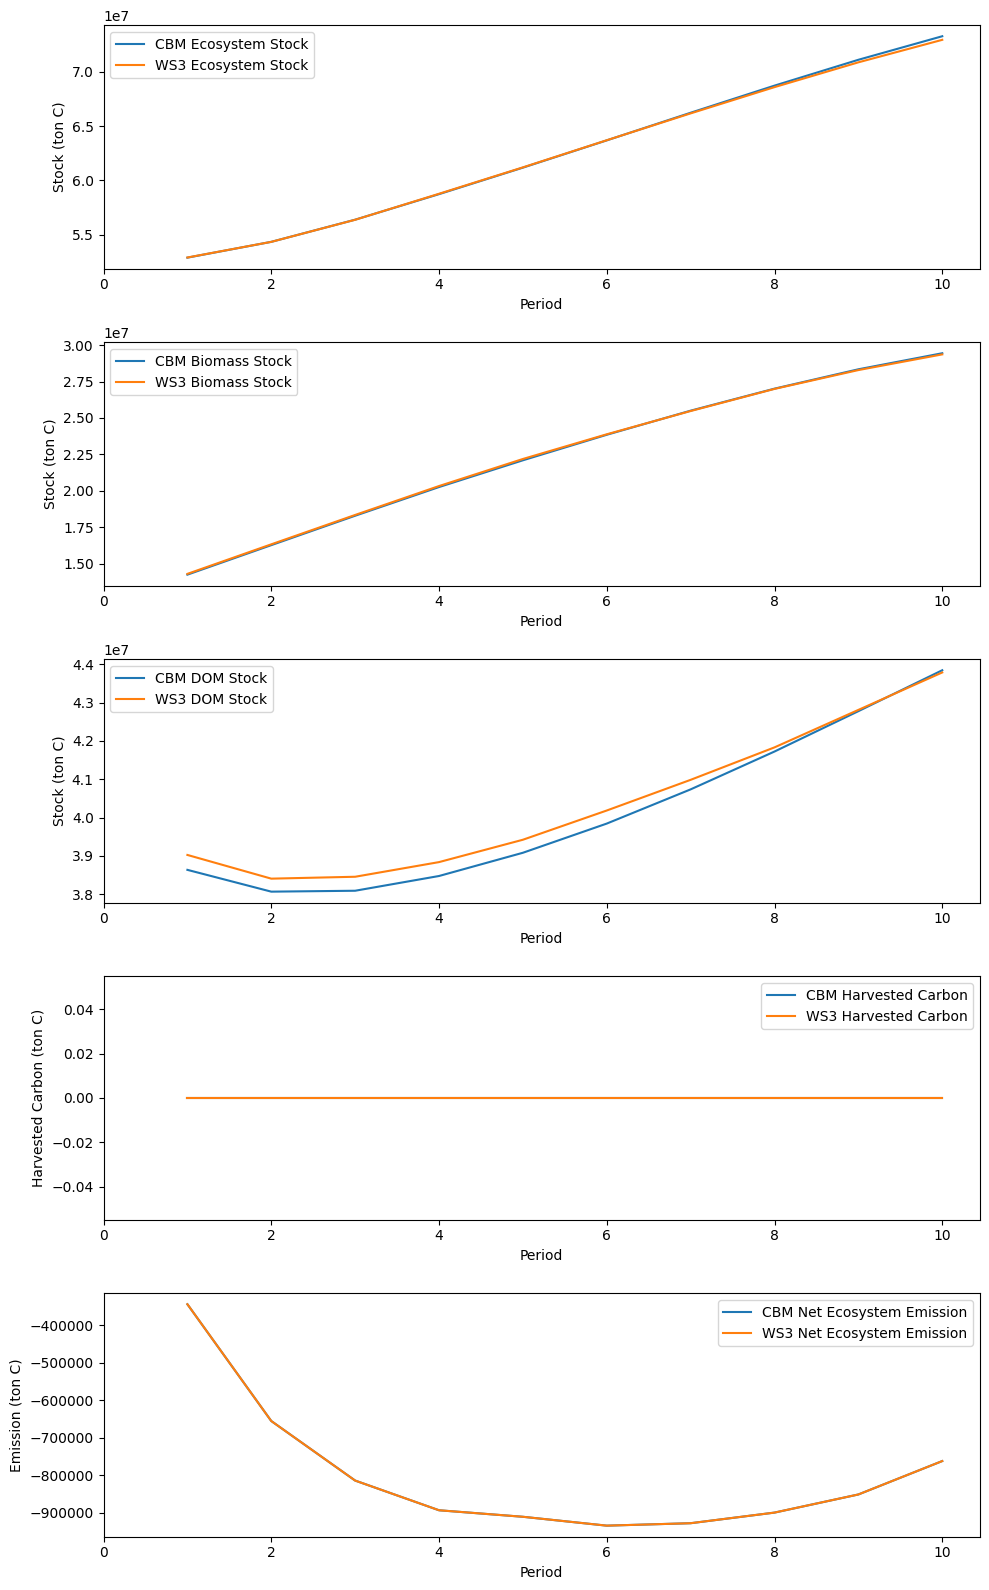

(   period  biomass_stock     dom_stock     eco_stock  total_emission  \
 0       1   1.423830e+07  3.863534e+07  5.287364e+07    3.245169e+06   
 1       2   1.626471e+07  3.806644e+07  5.433115e+07    3.213583e+06   
 2       3   1.828427e+07  3.809009e+07  5.637435e+07    3.291613e+06   
 3       4   2.025381e+07  3.847495e+07  5.872876e+07    3.412292e+06   
 4       5   2.209131e+07  3.908150e+07  6.117281e+07    3.548385e+06   
 5       6   2.384425e+07  3.984339e+07  6.368764e+07    3.689793e+06   
 6       7   2.549859e+07  4.073631e+07  6.623491e+07    3.833769e+06   
 7       8   2.701085e+07  4.172410e+07  6.873496e+07    3.973222e+06   
 8       9   2.834004e+07  4.277782e+07  7.111786e+07    4.101746e+06   
 9      10   2.944286e+07  4.384605e+07  7.328891e+07    4.211848e+06   
 
    gross_growth  harvested_carbon   net_emission  
 0  3.589793e+06               0.0 -344624.352013  
 1  3.869338e+06               0.0 -655755.824444  
 2  4.106028e+06               0.0 -814

In [58]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, plots='individual')

In [ ]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")